<a href="https://www.kaggle.com/code/pankajkumar2002/starting-with-topic-modelling?scriptVersionId=153319816" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <h1 style='color:red; font-size:38px; border:2px solid red; border-radius:20px;'><center> Topic Modelling </center></h1>

![](https://miro.medium.com/max/1400/1*jpytbqadO3FtdIyOjx2_yg.png)

# <h1 style='color:red; font-size:38px; border:2px solid red; border-radius:20px;'><center> Feature Engineering </center></h1>

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import re
import string
import nltk
import pyLDAvis
import warnings
from tqdm import tqdm

import spacy
import nltk
import pyLDAvis.gensim
import gensim
from gensim import corpora

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from tqdm.notebook import tqdm_notebook
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models.coherencemodel import CoherenceModel

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

<p style='font-size:25px;'> Configurations of Notebook </p>

In [2]:
warnings.filterwarnings('ignore')
tqdm_notebook.pandas()
pyLDAvis.enable_notebook()
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h1> <b> Dealing with datasets,  preprocessing of data & Feature Selection </b> </h1>

In [3]:
df = pd.read_csv('../input/cyber-bullying/cyberbullying1.csv')
df.head()

,Unnamed: 0,index,Datetime,Tweet Id,Text,Username,hashtags,location
0,0,0,2022-02-16 23:48:30+00:00,1494096378284359680,Ask A Therapist: How Can I Protect My Child fr...,bcbssc,['cyberbullying'],"South Carolina, USA"
1,1,1,2022-02-16 23:36:08+00:00,1494093267616485381,#IStandWithNicky #Twitter #Harassment #FalseAc...,RLJewperhero,"['IStandWithNicky', 'Twitter', 'Harassment', '...","Bakersfield, CA"
2,2,2,2022-02-16 23:33:33+00:00,1494092618480771073,#IStandWithNicky #Twitter #CheckTheFacts #Brok...,RLJewperhero,"['IStandWithNicky', 'Twitter', 'CheckTheFacts'...","Bakersfield, CA"
3,3,3,2022-02-16 23:31:26+00:00,1494092084118274052,#Cyberbullying pode Aumentar Insônia e Depress...,drrondojr,"['Cyberbullying', 'Bullying']",São Paulo
4,4,4,2022-02-16 22:31:12+00:00,1494076927329644549,Shout out to our #cyberbullying course that he...,iAchieveLS,"['cyberbullying', 'SaferInternetDay']",NaN


US Covid-19 Dataset

In [4]:
us_covid_dataset = pd.read_csv('../input/us-counties-covid-19-dataset/us-counties.csv')
us_covid_dataset.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


Following code calculates the frequency of covid cases on a Particular Date

In [5]:
def covid_frequency(dataset):
    date_wise_covid = dataset.groupby('date')
    covid_series = date_wise_covid.describe().iloc[:, 0]
    covid_df = pd.DataFrame(covid_series)
    covid_df.columns = ['frequency']
    covid_df = covid_df.reset_index()
    covid_df['date'] = covid_df['date'].astype('datetime64[ns]')
    covid_df = covid_df.sort_values(by=['date'])
    covid_df['frequency'] = covid_df['frequency'].astype('int')

    return covid_df

covid_df = covid_frequency(us_covid_dataset)
print(covid_df)
print(covid_df.info())

          date  frequency
0   2020-01-21          1
1   2020-01-22          1
2   2020-01-23          1
3   2020-01-24          2
4   2020-01-25          3
..         ...        ...
839 2022-05-09       3220
840 2022-05-10       3220
841 2022-05-11       3220
842 2022-05-12       3220
843 2022-05-13       3220

[844 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       844 non-null    datetime64[ns]
 1   frequency  844 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.8 KB
None


In [6]:
df = df[['Datetime', 'Text', 'hashtags', 'location']]
print(df.head(), end='\n\n')
print(df.info(), end='\n\n')
print(df.isnull().sum())

                    Datetime  \
0  2022-02-16 23:48:30+00:00   
1  2022-02-16 23:36:08+00:00   
2  2022-02-16 23:33:33+00:00   
3  2022-02-16 23:31:26+00:00   
4  2022-02-16 22:31:12+00:00   

                                                Text  \
0  Ask A Therapist: How Can I Protect My Child fr...   
1  #IStandWithNicky #Twitter #Harassment #FalseAc...   
2  #IStandWithNicky #Twitter #CheckTheFacts #Brok...   
3  #Cyberbullying pode Aumentar Insônia e Depress...   
4  Shout out to our #cyberbullying course that he...   

                                            hashtags             location  
0                                  ['cyberbullying']  South Carolina, USA  
1  ['IStandWithNicky', 'Twitter', 'Harassment', '...      Bakersfield, CA  
2  ['IStandWithNicky', 'Twitter', 'CheckTheFacts'...      Bakersfield, CA  
3                      ['Cyberbullying', 'Bullying']            São Paulo  
4              ['cyberbullying', 'SaferInternetDay']                  NaN  

<class 'panda

In [7]:
df['location']=df['location'].fillna('')
df['Datetime'] = df['Datetime'].map(lambda x : x[:10])
print(df.head())

     Datetime                                               Text  \
0  2022-02-16  Ask A Therapist: How Can I Protect My Child fr...   
1  2022-02-16  #IStandWithNicky #Twitter #Harassment #FalseAc...   
2  2022-02-16  #IStandWithNicky #Twitter #CheckTheFacts #Brok...   
3  2022-02-16  #Cyberbullying pode Aumentar Insônia e Depress...   
4  2022-02-16  Shout out to our #cyberbullying course that he...   

                                            hashtags             location  
0                                  ['cyberbullying']  South Carolina, USA  
1  ['IStandWithNicky', 'Twitter', 'Harassment', '...      Bakersfield, CA  
2  ['IStandWithNicky', 'Twitter', 'CheckTheFacts'...      Bakersfield, CA  
3                      ['Cyberbullying', 'Bullying']            São Paulo  
4              ['cyberbullying', 'SaferInternetDay']                       


<h1> <b>The below function in the code is used to calculate the relative frequency of tweets with respect to social, education and gaming background which is result of grouping by date. </b> </h1>

In [8]:
def tweets_frequency(df):
    tweets_freq = df.loc[df.location.str.contains('USA', case=False) | 
                         df.location.str.contains('CA', case=False) | 
                         df.location.str.contains('brooklyn', case=False) |
                         df.location.str.contains('ny', case=False)].groupby('Datetime')

    tweets_freq = tweets_freq.describe().iloc[:, 0]
    tweets_freq = tweets_freq.reset_index()
    tweets_freq.columns = ['date', 'freq']
    tweets_freq['date'] = tweets_freq['date'].astype('datetime64[ns]')
    tweets_freq = tweets_freq.sort_values(by=['date'])
    tweets_freq['freq'] = tweets_freq['freq'].astype('int')
    
    return tweets_freq
    
tweets_freq = tweets_frequency(df)
print(tweets_freq, end='\n\n')
print(tweets_freq.info())

          date  freq
0   2019-06-01     9
1   2019-06-02     3
2   2019-06-03    16
3   2019-06-04    21
4   2019-06-05    17
..         ...   ...
984 2022-02-12     4
985 2022-02-13     2
986 2022-02-14     5
987 2022-02-15     3
988 2022-02-16     8

[989 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 988
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    989 non-null    datetime64[ns]
 1   freq    989 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 23.2 KB
None


<h1> <b> Frequency of tweets belongs to education from America </b> </h1>

In [9]:
def Education_tweets_frequency():
    edu_tweets = df.loc[ df.hashtags.str.contains("teach", case=False) |
                     df.hashtags.str.contains("colegios", case=False) | 
                     df.hashtags.str.contains("edchatie", case=False) |
                     df.hashtags.str.contains("educator", case=False) |
                     df.hashtags.str.contains("edtech", case=False) |
                     df.hashtags.str.contains("online", case=False) | 
                     df.hashtags.str.contains("udemy", case=False) | 
                     df.hashtags.str.contains("edu", case=False) | 
                     df.hashtags.str.contains("elearning", case=False) | 
                     df.hashtags.str.contains("remote", case=False) | 
                     df.hashtags.str.contains("onlineclasses", case=False) | 
                     df.hashtags.str.contains("k12", case=False) | 
                     df.hashtags.str.contains("students", case=False) | 
                     df.hashtags.str.contains("school", case=False) | 
                     df.hashtags.str.contains("teacher", case=False) & 
                     df.location.str.contains('USA', case=False) | 
                     df.location.str.contains('CA', case=False) |
                     df.location.str.contains('brooklyn', case=False) |
                     df.location.str.contains('ny', case=False)
                    ].groupby('Datetime')

    edu_tweets = edu_tweets.describe().iloc[:, 0]
    edu_tweets = edu_tweets.reset_index()
    edu_tweets.columns = ['date', 'freq']
    edu_tweets['date'] = edu_tweets['date'].astype('datetime64[ns]')
    edu_tweets = edu_tweets.sort_values(by=['date'])
    edu_tweets['freq'] = edu_tweets['freq'].astype('int')
    return edu_tweets

edu_tweets = Education_tweets_frequency()
print(edu_tweets)

          date  freq
0   2019-06-01    13
1   2019-06-02     6
2   2019-06-03    12
3   2019-06-04    24
4   2019-06-05    21
..         ...   ...
985 2022-02-12     8
986 2022-02-13     5
987 2022-02-14    10
988 2022-02-15     9
989 2022-02-16    17

[990 rows x 2 columns]


<h1> <b> Frequency of tweets that belong to online gaming from America </b></h1>

In [10]:
def game_tweets_frequency(df):
    game_tweets = df.loc[
                     df.hashtags.str.contains("game", case=False) | 
                     df.hashtags.str.contains("gaming", case=False) | 
                     df.hashtags.str.contains("pubg", case=False) | 
                     df.hashtags.str.contains("onlinegame", case=False) | 
                     df.hashtags.str.contains("cyberpunk", case=False)  &
                     df.location.str.contains("usa", case=False) |
                     df.location.str.contains("ca", case=False) | 
                     df.location.str.contains("brooklyn", case=False) |
                     df.location.str.contains("ny", case=False)
                     ].groupby('Datetime')

    game_tweets = game_tweets.describe().iloc[:, 0]
    game_tweets = game_tweets.reset_index()
    game_tweets.columns = ['date', 'freq']
    game_tweets['date'] = game_tweets['date'].astype('datetime64[ns]')
    game_tweets = game_tweets.sort_values(by=['date'])
    game_tweets['freq'] = game_tweets['freq'].astype('int')
    return game_tweets

game_tweets = game_tweets_frequency(df)
game_tweets

,date,freq
0,2019-06-01,8
1,2019-06-02,2
2,2019-06-03,6
3,2019-06-04,16
4,2019-06-05,13
...,...,...
977,2022-02-12,3
978,2022-02-13,1
979,2022-02-14,4
980,2022-02-15,5


<h1> <b>Tweets regarding Social media tags from United States  </b> </h1>

In [11]:
def social_tweets_frequency(df):
    social_tweets = df.loc[
                     df.hashtags.str.contains("insta", case=False) | 
                     df.hashtags.str.contains("facebook", case=False) | 
                     df.hashtags.str.contains("snap", case=False) | 
                     df.hashtags.str.contains("twitter", case=False) | 
                     df.hashtags.str.contains("tictok", case=False) |
                     df.hashtags.str.contains("tiktok", case=False)  &
                     df.location.str.contains("usa", case=False) |
                     df.location.str.contains("ca", case=False) | 
                     df.location.str.contains("brooklyn", case=False) |
                     df.location.str.contains("ny", case=False)
                     ].groupby('Datetime')
    
    social_tweets = social_tweets.describe().iloc[:, 0]
    social_tweets = social_tweets.reset_index()
    social_tweets.columns = ['date', 'freq']
    social_tweets['date'] = social_tweets['date'].astype('datetime64[ns]')
    social_tweets = social_tweets.sort_values(by=['date'])
    social_tweets['freq'] = social_tweets['freq'].astype('int')
    return social_tweets

social_tweets = social_tweets_frequency(df)
print(social_tweets)

          date  freq
0   2019-06-01    10
1   2019-06-02     5
2   2019-06-03     7
3   2019-06-04    21
4   2019-06-05    17
..         ...   ...
982 2022-02-12     3
983 2022-02-13     3
984 2022-02-14     4
985 2022-02-15     1
986 2022-02-16     7

[987 rows x 2 columns]


In [12]:
print('Head : ', covid_df.head())
print('Tail : ', covid_df.tail())
print('\n\n\n')
print('Head : ', tweets_freq.head())
print('Tail : ', tweets_freq.tail())

Head :          date  frequency
0 2020-01-21          1
1 2020-01-22          1
2 2020-01-23          1
3 2020-01-24          2
4 2020-01-25          3
Tail :            date  frequency
839 2022-05-09       3220
840 2022-05-10       3220
841 2022-05-11       3220
842 2022-05-12       3220
843 2022-05-13       3220




Head :          date  freq
0 2019-06-01     9
1 2019-06-02     3
2 2019-06-03    16
3 2019-06-04    21
4 2019-06-05    17
Tail :            date  freq
984 2022-02-12     4
985 2022-02-13     2
986 2022-02-14     5
987 2022-02-15     3
988 2022-02-16     8


<h1> <b>Selecting covid cases and tweets on the same dates from available Dataset.  </b> </h1>

# <h1 style='color:red; font-size:38px; border:2px solid red; border-radius:20px;'><center> Data Visualization </center></h1>

In [13]:
def Tweets_Distribution(t1, t2, t3):
    fig = make_subplots(rows=3, cols=1, y_title='Frequency', x_title='Date', shared_xaxes=True)
    fig.add_trace(go.Scatter(x=t1['date'], y=t1['freq'], name='Education Tweets'), row=1, col=1 )
    fig.add_trace(go.Scatter(x=t2['date'], y=t2['freq'], name='Game Tweets'), row=2, col=1 )
    fig.add_trace(go.Scatter(x=t3['date'], y=t3['freq'], name='Social Tweets'), row=3, col=1 )
    fig.update_layout(template='plotly_dark', height=800, width=1000, title='Tweets Distribution', hovermode='x unified')
    fig.show()
    
edu_tweets = edu_tweets[edu_tweets['date'] !='2020-11-18']
game_tweets_ = game_tweets[game_tweets['date'] !='2020-11-18']
social_tweets_ = social_tweets[social_tweets['date'] !='2020-11-18']

Tweets_Distribution(edu_tweets, game_tweets_, social_tweets_)

<h1> <b> Distribution of tweets and covid cases.</b> </h1> 

In [14]:
def Tweets_Covid(plt1, plt2):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=plt1['date'], y=plt1['freq'],  name='Tweets'), row=1, col=1,)
    fig.add_trace(go.Scatter(x=plt2['date'], y=plt2['frequency'], name='Covid Cases'), row=2, col=1)
    fig.update_layout(template='plotly_dark', height=800, width=1000, yaxis1_title='Frequency', xaxis1_title='Date')
    fig.show()

tweets_freq = tweets_freq[tweets_freq['date'] !='2020-11-18']
Tweets_Covid(tweets_freq, covid_df)

<h1><center> <b> Preparing the Dataset for Topic Modelling </b>  </center></h1>

In [15]:
education_tweets = df.loc[ df.hashtags.str.contains("teach", case=False) |
                     df.hashtags.str.contains("colegios", case=False) | 
                     df.hashtags.str.contains("edchatie", case=False) |
                     df.hashtags.str.contains("educator", case=False) |
                     df.hashtags.str.contains("edtech", case=False) |
                     df.hashtags.str.contains("online", case=False) | 
                     df.hashtags.str.contains("udemy", case=False) | 
                     df.hashtags.str.contains("edu", case=False) | 
                     df.hashtags.str.contains("elearning", case=False) | 
                     df.hashtags.str.contains("remote", case=False) | 
                     df.hashtags.str.contains("onlineclasses", case=False) | 
                     df.hashtags.str.contains("k12", case=False) | 
                     df.hashtags.str.contains("students", case=False) | 
                     df.hashtags.str.contains("school", case=False) | 
                     df.hashtags.str.contains("teacher", case=False) & 
                     df.location.str.contains('USA', case=False) | 
                     df.location.str.contains('CA', case=False) |
                     df.location.str.contains('brooklyn', case=False) |
                     df.location.str.contains('ny', case=False)
                    ]

education_tweets = education_tweets.drop(['hashtags', 'location'], axis=1)
education_tweets

,Datetime,Text
0,2022-02-16,Ask A Therapist: How Can I Protect My Child fr...
1,2022-02-16,#IStandWithNicky #Twitter #Harassment #FalseAc...
2,2022-02-16,#IStandWithNicky #Twitter #CheckTheFacts #Brok...
8,2022-02-16,According to PREVENet over one-third of Canadi...
12,2022-02-16,It's #wednesdaywisdom. Typically we think of #...
...,...,...
63795,2019-06-01,Give your daughter this when the cool girls R ...
63796,2019-06-01,Shame Belongs To The Cruel: Quote of the day h...
63799,2019-06-01,An efficient VPN can protect your kids’ digita...
63800,2019-06-01,@HobbesQ #cyberbullying https://t.co/b2IolQTGyG


In [16]:
social_tweets = df.loc[  df.hashtags.str.contains("insta", case=False) | 
                     df.hashtags.str.contains("facebook", case=False) | 
                     df.hashtags.str.contains("snap", case=False) | 
                     df.hashtags.str.contains("twitter", case=False) | 
                     df.hashtags.str.contains("tictok", case=False) |
                     df.hashtags.str.contains("tiktok", case=False)  &
                     df.location.str.contains("usa", case=False) |
                     df.location.str.contains("ca", case=False) | 
                     df.location.str.contains("brooklyn", case=False) |
                     df.location.str.contains("ny", case=False)
                     ]
social_tweets = social_tweets.drop(['hashtags', 'location'], axis=1)
social_tweets

,Datetime,Text
0,2022-02-16,Ask A Therapist: How Can I Protect My Child fr...
1,2022-02-16,#IStandWithNicky #Twitter #Harassment #FalseAc...
2,2022-02-16,#IStandWithNicky #Twitter #CheckTheFacts #Brok...
33,2022-02-16,Give your daughter this when the cool girls R ...
37,2022-02-16,RESCHEDULED: Are you aware of today’s dangers ...
...,...,...
63795,2019-06-01,Give your daughter this when the cool girls R ...
63796,2019-06-01,Shame Belongs To The Cruel: Quote of the day h...
63800,2019-06-01,@HobbesQ #cyberbullying https://t.co/b2IolQTGyG
63801,2019-06-01,Global non-profit organization @Kidpower_Intl ...


In [17]:
game_tweets = df.loc[  df.hashtags.str.contains("gta", case=False) | 
                     df.hashtags.str.contains("onlinegam", case=False) | 
                     df.hashtags.str.contains("pubg", case=False) | 
                     df.hashtags.str.contains("game", case=False) | 
                     df.hashtags.str.contains("gaming", case=False) |
                     df.hashtags.str.contains("cyberpunk", case=False)  &
                     df.location.str.contains("usa", case=False) |
                     df.location.str.contains("ca", case=False) | 
                     df.location.str.contains("brooklyn", case=False) |
                     df.location.str.contains("ny", case=False)
                     ]
game_tweets = game_tweets.drop(['hashtags', 'location'], axis=1)
game_tweets

,Datetime,Text
0,2022-02-16,Ask A Therapist: How Can I Protect My Child fr...
1,2022-02-16,#IStandWithNicky #Twitter #Harassment #FalseAc...
2,2022-02-16,#IStandWithNicky #Twitter #CheckTheFacts #Brok...
33,2022-02-16,Give your daughter this when the cool girls R ...
37,2022-02-16,RESCHEDULED: Are you aware of today’s dangers ...
...,...,...
63789,2019-06-01,“las víctimas de cyber-bullying muestran 2 vec...
63795,2019-06-01,Give your daughter this when the cool girls R ...
63796,2019-06-01,Shame Belongs To The Cruel: Quote of the day h...
63800,2019-06-01,@HobbesQ #cyberbullying https://t.co/b2IolQTGyG


In [18]:
def process_tweet(tweet):
    
    wordnet_lemmatizer = WordNetLemmatizer()   
    
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub('\n', ' ', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r"[^a-zA-Z0-9.?! ]+", "", tweet)
    tweet=tweet.lower()
    tweet_tokens = nltk.word_tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if ( word not in set(stopwords.words('english')) and word not in string.punctuation and len(word) > 2): 
            s=wordnet_lemmatizer.lemmatize(word)
            tweets_clean.append(s)
    
    return tweets_clean

In [19]:
tweets_edu = education_tweets['Text'].progress_apply(lambda x:process_tweet(str(x)))
tweets_social = social_tweets['Text'].progress_apply(lambda x:process_tweet(str(x)))
tweets_game = game_tweets['Text'].progress_apply(lambda x:process_tweet(str(x)))

tweets_edu = tweets_edu.to_list()
tweets_social = tweets_social.to_list()
tweets_game = tweets_game.to_list()

  0%|          | 0/14857 [00:00<?, ?it/s]

  0%|          | 0/8242 [00:00<?, ?it/s]

  0%|          | 0/7350 [00:00<?, ?it/s]

In [20]:
def ngrams(tweets):
    bigram = gensim.models.Phrases(tweets, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[tweets], threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigram(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowd_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    text_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent))
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowd_postags])
    
    return text_out

In [21]:
edu_bigram, edu_trigram = ngrams(tweets_edu)
social_bigram, social_trigram = ngrams(social_tweets)
game_bigram, game_trigram = ngrams(game_tweets)

edu_tweet_bigram = make_bigrams(tweets_edu, edu_bigram)
social_word_bigrams = make_bigrams(social_tweets, social_bigram)
game_word_bigrams = make_bigrams(game_tweets, game_bigram)

# <h1 style='color:red; font-size:38px; border:2px solid red; border-radius:20px;'><center> Model Selection and Hypertuning </center></h1>

In [22]:
def compute_coherence_values(corpus, tweets, dictionary, k, a, b):
        
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary, 
                                            num_topics=k, 
                                            random_state=100, 
                                            update_every=1, 
                                            chunksize=100, 
                                            passes=10, 
                                            alpha=a,
                                            eta=b,
                                            per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=model, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda
    

In [23]:
def tweets_lda_model(tweets):
    
    tweets_lemmatized = lemmatization(tweets)
    id2word = corpora.Dictionary(tweets_lemmatized)
    corpus = [id2word.doc2bow(text) for text in tweets_lemmatized]
    
    
    topics_range = range(1, 20, 1)
 #   alpha = list(np.arange(0.01, 1, 0.3))
 #   beta = list(np.arange(0.01, 1, 0.3))
    
    model_results = {'Topics': [],
          #           'Alpha': [],
          #           'Beta': [],
                     'Coherence': []
                }
    
    for k in tqdm(topics_range):
    #    for a in alpha:
    #       for b in beta:
        cv = compute_coherence_values(corpus=corpus, tweets=tweets_lemmatized, dictionary=id2word, 
                                      k=k, a='auto', b=None)
        model_results['Topics'].append(k)
      #  model_results['Alpha'].append(a)
      #  model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
    
    return pd.DataFrame(model_results)

hypertuned_edu_lda_models = tweets_lda_model(tweets_edu)
hypertuned_social_lda_model = tweets_lda_model(tweets_social)
hypertuned_game_lda_model = tweets_lda_model(tweets_game)

100%|██████████| 19/19 [08:45<00:00, 27.68s/it]


In [24]:
fig = make_subplots(rows=3, cols=1, x_title='Topics', y_title='Coherence', shared_xaxes=True)
fig.add_trace(go.Scatter(x=hypertuned_edu_lda_models['Topics'], y=hypertuned_edu_lda_models['Coherence'], name='Education model'), row=1, col=1)
fig.add_trace(go.Scatter(x=hypertuned_social_lda_model['Topics'], y=hypertuned_social_lda_model['Coherence'], name='Social Model'), row=2, col=1)
fig.add_trace(go.Scatter(x=hypertuned_game_lda_model['Topics'], y=hypertuned_game_lda_model['Coherence'], name='Game Model'), row=3, col=1)
fig.update_layout(template='plotly_dark', width=1000, hovermode='x unified')
fig.show()

In [25]:
def final_model(tweets, k, a='auto', b=None, cat=None):
    
    tweets_lemmatized = lemmatization(tweets)
    id2word = corpora.Dictionary(tweets_lemmatized)
    corpus = [id2word.doc2bow(text) for text in tweets_lemmatized]
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=id2word, 
                                            num_topics=k, 
                                            random_state=100, 
                                            update_every=1, 
                                            chunksize=100, 
                                            passes=10, 
                                            alpha='auto',
                                            eta=b,
                                            per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=model, texts=tweets_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
    print('Coherence Score for {} tweets is : {}'.format(cat, coherence_lda))
    return model, vis

In [26]:
edu_model, edu_vis = final_model(tweets_edu, 3 )
pyLDAvis.display(edu_vis, local=True)

100%|██████████| 14857/14857 [01:03<00:00, 233.31it/s]


Coherence Score for None tweets is : 0.46027150736080363


In [27]:
social_model, social_vis = final_model(tweets_social, 3 )
pyLDAvis.display(social_vis, local=True)

100%|██████████| 8242/8242 [00:36<00:00, 225.75it/s]


Coherence Score for None tweets is : 0.39822752170163794


In [28]:
game_model, game_vis = final_model(tweets_game, 4 )
pyLDAvis.display(game_vis, local=True)

100%|██████████| 7350/7350 [00:32<00:00, 225.00it/s]


Coherence Score for None tweets is : 0.36462911431926803


In [29]:
def WordClouds(model, _t=3):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs:cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)
    fig, axes = plt.subplots(1, _t, figsize=(15, 15), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic '+str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

<h1> <b> WordCloud for Education topics </b></h1>

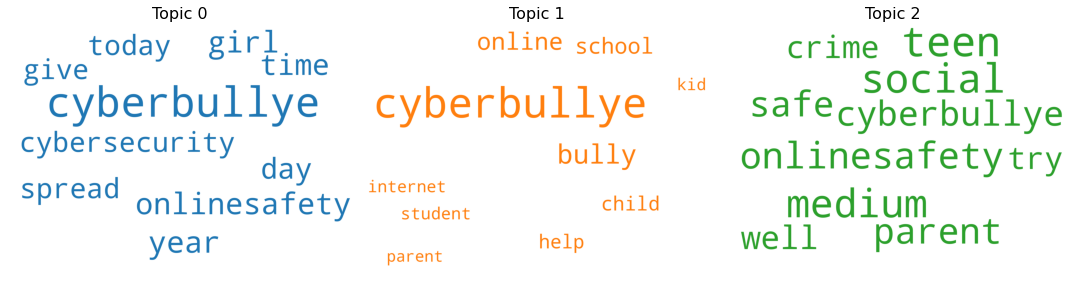

In [30]:
WordClouds(edu_model, 3)

<h1> <b> WordlCloud for Social topics </b></h1>

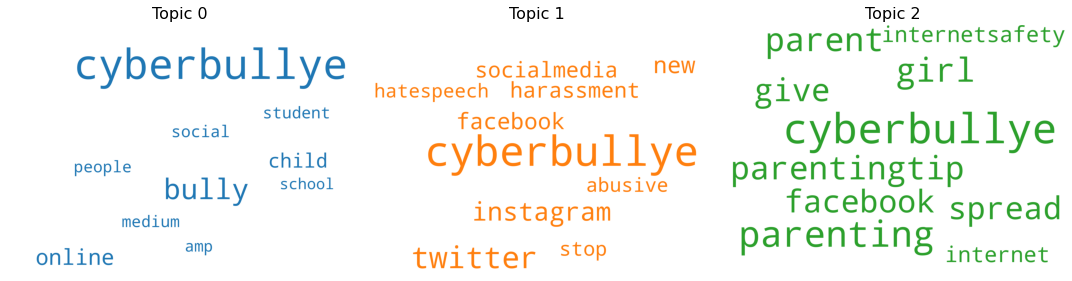

In [31]:
WordClouds(social_model, 3)

<h1> <b> Wordcloud for Game topics </b></h1>

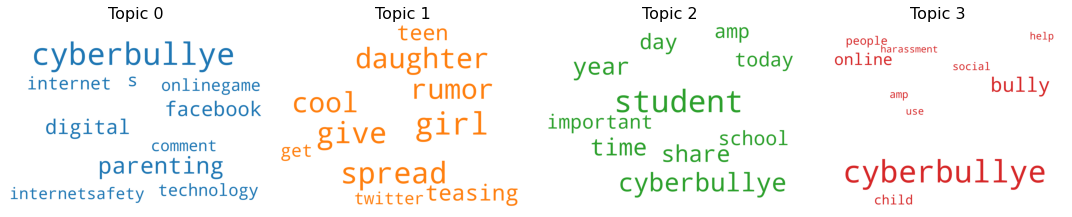

In [32]:
WordClouds(game_model, 4)

In [33]:
final_dict = {'Date':covid_df['date'], 
              'Covid_Cases':covid_df['frequency'], 
              'Education_tweets':edu_tweets['freq'], 
              'Social_tweets':social_tweets_['freq'], 
              'Game_tweets':game_tweets_['freq'], 
              'Overall_Cyberbullying': tweets_freq['freq'] }
final_df = pd.DataFrame(final_dict)
print(final_df.head())
final_df.to_csv('Submission.csv', index=False)

        Date  Covid_Cases  Education_tweets  Social_tweets  Game_tweets  \
0 2020-01-21          1.0              13.0           10.0          8.0   
1 2020-01-22          1.0               6.0            5.0          2.0   
2 2020-01-23          1.0              12.0            7.0          6.0   
3 2020-01-24          2.0              24.0           21.0         16.0   
4 2020-01-25          3.0              21.0           17.0         13.0   

   Overall_Cyberbullying  
0                    9.0  
1                    3.0  
2                   16.0  
3                   21.0  
4                   17.0  


In [34]:
!head Submission.csv

Date,Covid_Cases,Education_tweets,Social_tweets,Game_tweets,Overall_Cyberbullying
2020-01-21,1.0,13.0,10.0,8.0,9.0
2020-01-22,1.0,6.0,5.0,2.0,3.0
2020-01-23,1.0,12.0,7.0,6.0,16.0
2020-01-24,2.0,24.0,21.0,16.0,21.0
2020-01-25,3.0,21.0,17.0,13.0,17.0
2020-01-26,5.0,22.0,14.0,12.0,14.0
2020-01-27,5.0,16.0,13.0,12.0,12.0
2020-01-28,5.0,12.0,5.0,4.0,4.0
2020-01-29,5.0,16.0,13.0,12.0,13.0


# <h1 style='color:red; font-size:38px; border:2px solid red; border-radius:20px;'><center> Thank You! </center></h1>